In [2]:
%matplotlib inline

In [3]:
import torch
import torch.nn as nn            # containing various building blocks for your neural networks
import torch.optim as optim      # implementing various optimization algorithms
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface

# torchvision: popular datasets, model architectures, and common image transformations for computer vision.
import torchvision
# transforms: transformations useful for image processing
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, random_split

import glob
import os.path as osp
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from collections import  Counter
#from torchtext import data
import gensim.downloader as api
from sklearn.metrics import fbeta_score

## load caption embeddings

In [5]:
seq_embeddings = np.load('nlp_embeddings.npy')
seq_embeddings = torch.from_numpy(seq_embeddings)
seq_embeddings.shape

torch.Size([30000, 28, 25])

In [6]:
seq_embeddings_test = np.load('nlp_embeddings_test.npy')
seq_embeddings_test = torch.from_numpy(seq_embeddings_test)
seq_embeddings_test.shape

torch.Size([10000, 28, 25])

## encode labels

In [7]:
df_train_label = pd.read_csv('train.csv')
train_label = np.array(df_train_label[['Labels']])
train_label_list = []
for i in train_label:
    for k in i:
        train_label_list.append([int(j) for j in k.split(' ')])

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(train_label_list)
y_train = mlb.transform(train_label_list)
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [9]:
mlb.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
       19])

In [10]:
y_train_t = torch.FloatTensor(y_train)
y_train_t

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

## custom dataset

In [11]:
class A2data(Dataset):
    """
    A customized data loader for MNIST.
    """
    def __init__(self,
                 root,labels=None,seq_embeddings=None,
                 transform=None,
                 preload=False, test=False):
        """ Intialize the MNIST dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.images = None
        if not labels is None:
            self.labels = labels
        self.seq_embeddings = seq_embeddings
        self.filenames = []
        self.root = root
        self.transform = transform
        self.test = test    
        # read filenames
        if self.test == False:
            for i in range(30000):
                filename = self.root + str(i) + '.jpg'
                self.filenames.append(filename)
        else:
            for i in range(30000,40000):
                filename = self.root + str(i) + '.jpg'
                self.filenames.append(filename)            

        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        self.images = []
        for image_fn in self.filenames:            
            # load images
            image = Image.open(image_fn)
            self.images.append(image.copy())
            # avoid too many opened files bug
            image.close()

    # probably the most important to customize.
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.test == False:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
            embeddings = self.seq_embeddings[index]
            # May use transform function to transform samples
            # e.g., random crop, whitening
            if self.transform is not None:
                image = self.transform(image)
            # return image and label
            return image, label, embeddings
        else:
            image = self.images[index]
            embeddings = self.seq_embeddings[index]
            if self.transform is not None:
                image = self.transform(image)
            # return image and label
            return image, embeddings
        
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

## resize images

In [12]:
data_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
])

In [13]:
trainset = A2data(
    root='data/',labels=y_train_t,seq_embeddings=seq_embeddings,
    preload=True, transform=data_transform,test=False
)

In [14]:
len(trainset)

30000

In [15]:
testset = A2data(
    root='data/',labels=None, seq_embeddings=seq_embeddings_test,
    preload=True, transform=data_transform,test=True
)

In [16]:
len(testset)

10000

In [17]:
testset[0]

(tensor([[[-0.5082, -0.4054, -0.3369,  ..., -0.7650, -0.7308, -0.5596],
          [-1.8610, -1.7583, -1.6042,  ..., -0.8164, -0.7479, -0.4568],
          [-1.8953, -1.8268, -1.9295,  ..., -0.9192, -0.8335, -0.1657],
          ...,
          [ 0.7762,  0.9646,  0.3823,  ..., -0.9705, -0.8849, -0.7308],
          [ 0.4508,  0.5878,  0.2453,  ..., -0.7650, -0.7308, -0.7822],
          [ 0.0569,  0.5536,  0.4508,  ..., -0.7308, -0.7993, -0.9877]],
 
         [[-0.3901, -0.3025, -0.2150,  ..., -1.0378, -1.0028, -0.8102],
          [-1.7731, -1.6681, -1.5105,  ..., -1.1078, -1.0553, -0.6176],
          [-1.8256, -1.7556, -1.8606,  ..., -1.2654, -1.1078, -0.2325],
          ...,
          [ 1.0280,  1.1331,  0.0301,  ..., -1.7731, -1.7556, -1.6856],
          [ 0.6604,  0.8354, -0.0049,  ..., -1.7031, -1.6856, -1.7031],
          [ 0.3102,  0.7304,  0.6954,  ..., -1.7031, -1.7206, -1.7556]],
 
         [[-0.4450, -0.3753, -0.3055,  ..., -1.3513, -1.3339, -1.1770],
          [-1.6127, -1.5430,

## test DataLoader

In [18]:
trainset_loader = DataLoader(trainset, batch_size=5, shuffle=True, num_workers=0)

In [19]:
dataiter = iter(trainset_loader)
images, labels, embeddings = dataiter.next()

In [20]:
embeddings.shape

torch.Size([5, 28, 25])

In [21]:
testset_loader = DataLoader(testset, batch_size=5, shuffle=False, num_workers=0)

In [22]:
dataiter = iter(testset_loader)
images, embeddings = dataiter.next()

In [23]:
images.shape

torch.Size([5, 3, 32, 32])

## split train val dataset

In [64]:
train_set, val_set = random_split(trainset, (24000, 6000))

In [65]:
print(len(train_set), len(val_set))

24000 6000


In [66]:
train_set[3]

(tensor([[[-0.2513, -0.2342, -0.2171,  ..., -0.0287,  0.9132,  0.9303],
          [-0.2513, -0.2342, -0.1999,  ...,  0.7419,  1.3413,  1.1015],
          [-0.2342, -0.2171, -0.1828,  ...,  1.0844,  1.2043,  1.4269],
          ...,
          [ 1.5125,  1.6838,  1.8037,  ...,  1.3413,  1.1872,  1.0159],
          [ 1.9578,  2.0948,  2.1462,  ...,  1.5125,  1.3242,  1.1529],
          [ 1.8722,  2.0434,  2.1633,  ...,  1.6495,  1.4440,  1.2385]],
 
         [[-1.2304, -1.2129, -1.1954,  ..., -0.4076,  0.4853,  0.5028],
          [-1.2129, -1.1954, -1.1779,  ...,  0.3452,  0.9755,  0.6779],
          [-1.2129, -1.1779, -1.1604,  ...,  0.6779,  0.8179,  1.0805],
          ...,
          [ 1.4832,  1.7108,  1.8683,  ...,  1.3256,  1.1331,  0.9230],
          [ 2.0959,  2.2360,  2.3060,  ...,  1.5532,  1.3606,  1.1331],
          [ 2.0259,  2.2360,  2.3585,  ...,  1.8158,  1.5882,  1.3256]],
 
         [[-1.7696, -1.7696, -1.7696,  ..., -1.1247, -0.3753, -0.4450],
          [-1.7696, -1.7522,

## Visualize data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


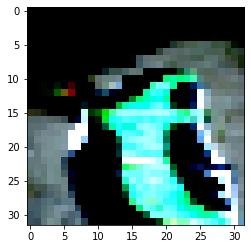

In [67]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow(train_set[1][0])

## test device

In [68]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## Define Conv Net

In [69]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=18):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out, torch.sigmoid(out)


def ResNet18():

    return ResNet(ResidualBlock)



## Define LSTM net

In [70]:
class Netrnn(nn.Module):
    def __init__(self):
        super(Netrnn, self).__init__()
        self.lstm = nn.LSTM(25, 32, batch_first =True, bidirectional=True, dropout=0.2)
        self.linear = nn.Linear(32*2,18)

    def forward(self, sentence):
        
        lstm_out, (h_n,c_n) = self.lstm(sentence)
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        output = self.linear(hidden_out)
        sig_output = torch.sigmoid(output)
        
        return output, sig_output

## Combine two nets

In [71]:
class Combine(nn.Module):
    def __init__(self):
        super(Combine, self).__init__()
        self.cnn = ResNet18()
        self.rnn = Netrnn()
        

    def forward(self, x, embeddings):
        output1, sig_output1 = self.cnn(x)
        output2, sig_output2 = self.rnn(embeddings)
        output = output1 + output2
        sig_output = torch.sigmoid(output)
        return output, sig_output
    
model = Combine().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

## Train the network

In [72]:
trainset_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
valset_loader = DataLoader(val_set, batch_size=100, shuffle=False, num_workers=0)
testset_loader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=0)

In [73]:
len(testset_loader.dataset)

10000

In [74]:
from time import time
def train(epoch, log_interval=100):
      # set training mode
    iteration = 0
    for ep in range(epoch):
        model.train()
        start = time()
        for batch_idx, (data, target, embeddings) in enumerate(trainset_loader):
            # bring data to the computing device, e.g. GPU
            data, target, embeddings = data.to(device), target.to(device), embeddings.float().to(device)

            # forward pass
            output, sig_x = model(x=data, embeddings=embeddings)
            criterion = nn.BCEWithLogitsLoss()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
          
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
                
            iteration += 1
            
        model.eval()
        outputs, sig_output = model(x=data, embeddings=embeddings)        
        pred_result_list = test()
        end = time()
        print('{:.2f}s'.format(end-start))
    return pred_result_list

## Test the val dataset

In [75]:
def test():
    model.eval()  # set evaluation mode
    f1_list = []
    pred_result_list = []
    with torch.no_grad():
        for data, target, embeddings in valset_loader:
            data = data.to(device)
            embeddings = embeddings.float().to(device)
            output, sig_x = model(data, embeddings)
            f1_list.append(fbeta_score(target.numpy(), sig_x.cpu().detach().numpy()>0.325,beta=1, average='samples'))
    f1_avg = sum(f1_list) / 60
    print('Overall F1-Score(samples): ', f1_avg)
    return pred_result_list

In [76]:
pred_result_list = train(10)

Train Epoch: 0 [0/24000 (0%)]	Loss: 0.783832
Train Epoch: 0 [6400/24000 (27%)]	Loss: 0.182566
Train Epoch: 0 [12800/24000 (53%)]	Loss: 0.153438
Train Epoch: 0 [19200/24000 (80%)]	Loss: 0.128349
Overall F1-Score(samples):  0.7601090187590189
30.05s
Train Epoch: 1 [1600/24000 (7%)]	Loss: 0.119310
Train Epoch: 1 [8000/24000 (33%)]	Loss: 0.117817
Train Epoch: 1 [14400/24000 (60%)]	Loss: 0.114039
Train Epoch: 1 [20800/24000 (87%)]	Loss: 0.116010
Overall F1-Score(samples):  0.8079265512265512
29.76s
Train Epoch: 2 [3200/24000 (13%)]	Loss: 0.166993
Train Epoch: 2 [9600/24000 (40%)]	Loss: 0.135047
Train Epoch: 2 [16000/24000 (67%)]	Loss: 0.134972
Train Epoch: 2 [22400/24000 (93%)]	Loss: 0.096270
Overall F1-Score(samples):  0.8266121693121691
29.89s
Train Epoch: 3 [4800/24000 (20%)]	Loss: 0.081860
Train Epoch: 3 [11200/24000 (47%)]	Loss: 0.128622
Train Epoch: 3 [17600/24000 (73%)]	Loss: 0.104215
Overall F1-Score(samples):  0.835837313612314
30.23s
Train Epoch: 4 [0/24000 (0%)]	Loss: 0.086648
Tr

In [49]:
def test_th():
    model.eval()  # set evaluation mode
    
    pred_result_list = []
    th = np.arange(0.20,0.55,0.005)
    for t in th:
        f1_list = []
        with torch.no_grad():
            for data, target, embeddings in valset_loader:
                data = data.to(device)
                embeddings = embeddings.float().to(device)
                output, sig_x = model(data, embeddings)
                f1_list.append(fbeta_score(target.numpy(), sig_x.cpu().detach().numpy()>t,beta=1, average='samples'))
            f1_avg = sum(f1_list) / 60
            print('Overall F1-Score(samples): %.4f threshold: %.3f' % (f1_avg, t))
    return pred_result_list

In [77]:
def test_label():
    model.eval()  # set evaluation mode
    pred_result_list = []
    
    with torch.no_grad():
        for data, embeddings in testset_loader:
            data = data.to(device)
            embeddings = embeddings.float().to(device)            
            output, sig_x = model(data, embeddings)
            predicted_labels = (sig_x.cpu().detach().numpy() > 0.325).astype(int)
            pred_result_list.append(predicted_labels)
    return pred_result_list

In [78]:
pred_result_list = test_label()

In [79]:
predicted_labels = np.array(pred_result_list).reshape(10000, 18).astype(int)

In [80]:
predicted_labels = mlb.inverse_transform(predicted_labels)

In [82]:
predicted_labels

[(1,),
 (1,),
 (1,),
 (1,),
 (1,),
 (1,),
 (11,),
 (1, 9),
 (1, 9),
 (1,),
 (1, 3, 6),
 (1, 18),
 (1, 7),
 (1,),
 (1,),
 (1,),
 (1, 3, 6, 10),
 (1,),
 (1, 3, 8),
 (1,),
 (1, 3),
 (1,),
 (1,),
 (1,),
 (5, 8),
 (17,),
 (1, 3, 8),
 (1, 7),
 (1, 8, 19),
 (1, 7),
 (1,),
 (5, 8),
 (1,),
 (1, 4),
 (1,),
 (1,),
 (1, 3, 8),
 (1,),
 (1,),
 (17,),
 (1,),
 (16,),
 (1, 7),
 (1,),
 (1,),
 (1,),
 (11, 18),
 (1,),
 (1,),
 (1,),
 (7,),
 (1,),
 (16,),
 (1,),
 (1, 8),
 (1,),
 (1,),
 (1, 15),
 (1, 3, 10),
 (1, 16),
 (1,),
 (1,),
 (1,),
 (1, 3, 6, 8, 10),
 (1,),
 (1,),
 (1,),
 (1,),
 (1,),
 (1, 19),
 (1,),
 (1,),
 (1, 7),
 (1,),
 (17,),
 (15, 17),
 (1,),
 (1, 13),
 (7,),
 (1,),
 (1,),
 (1,),
 (1,),
 (1,),
 (1,),
 (1, 7),
 (1, 17, 18),
 (1,),
 (1,),
 (1,),
 (1,),
 (1,),
 (1,),
 (1, 3, 6, 8, 10),
 (5,),
 (1,),
 (1,),
 (1,),
 (1,),
 (3, 10),
 (1, 10, 13),
 (3, 11),
 (1,),
 (5,),
 (1,),
 (1,),
 (1,),
 (1,),
 (17,),
 (1,),
 (17,),
 (1,),
 (1,),
 (1, 18),
 (1,),
 (1,),
 (1, 16),
 (17,),
 (1, 3, 4),
 (9,),
 (1, 3

In [83]:
labels = []
for i in predicted_labels:
    temp = ''
    for e in i:
        temp += str(e) + ' '
    temp = temp.rstrip()
    labels.append(temp)

In [84]:
result_temp = pd.DataFrame()
Id = [str(i)+'.jpg' for i in range(30000,40000)]
result_temp['ImageID'] = Id
result_temp['Labels'] = labels
result_temp.to_csv('result_temp.csv', index=False)

In [69]:
result_temp

,ImageID,Labels
0,30000.jpg,1
1,30001.jpg,1
2,30002.jpg,1
3,30003.jpg,1
4,30004.jpg,1
...,...,...
9995,39995.jpg,1
9996,39996.jpg,3 4
9997,39997.jpg,1
9998,39998.jpg,1
